In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
sns.set_palette('Dark2')

sns.set_style('whitegrid')
from ete3 import Tree

## Parse Metadata from GISAID

In [37]:
# ## Dataset far too big to include in repo
# metadata = pd.read_csv('/home/fin/Downloads/gisaid_metadata/gisaid_metadata_2022_03_08.tsv', sep='\t')

# def match_to_phylo_names(virus_name):
#     virus_name = virus_name.replace(' ', '_')
#     virus_name = virus_name.replace('hCoV-19/', '')
#     return virus_name

# metadata['Virus name'] = metadata['Virus name'].apply(lambda x: match_to_phylo_names(x))
# metadata = metadata.set_index('Virus name')

# samples_in_tree = []
# for leaf in tree.iter_leaf_names():
#     if leaf not in ['4538','4645', '4649', '4534', '4581','4662', '4658', 'MN908947.3']:
#         samples_in_tree.append(leaf)
# samples_in_tree = metadata.loc[samples_in_tree]

# #  
# wtd_metadata = pd.read_csv('../../tables/supplemental/S1_sample_data.tsv', sep=',')
# wtd_metadata['Virus name'] = wtd_metadata['WILD-CoV Sample ID'].str.replace('wcov-0', '')
# wtd_metadata['Collection date'] = wtd_metadata['Collection']
# wtd_metadata['Host'] = 'Odocoileus virginianus'
# deer_samples = wtd_metadata[wtd_metadata['Virus name'].isin(['4538','4645', '4649', '4534', '4581','4662', '4658'])][['Virus name', 'Collection date', 'Host']]
# root = pd.Series({'Virus name': 'MN908947.3', 'Host': 'Human', 'Collection date': '2019-12'} )
# root.name=8
# deer_samples = deer_samples.append(root)
# deer_samples = deer_samples.set_index("Virus name")

# all_samples_in_tree = pd.concat([samples_in_tree, deer_samples]) 
# all_samples_in_tree.to_csv('metadata_in_tree.tsv', sep='\t')

In [38]:
metadata = pd.read_csv('metadata_in_tree.tsv', sep='\t')

# drop samples with year only
metadata = metadata[metadata['Collection date'].apply(len) != 4]

def numeric_date(dt=None):
    """
    Convert datetime object to the numeric date.
    The numeric date format is YYYY.F, where F is the fraction of the year passed
    Parameters
    ----------
     dt:  datetime.datetime, None
        date of to be converted. if None, assume today
    """
    from calendar import isleap

    if dt is None:
        dt = datetime.datetime.now()

    days_in_year = 366 if isleap(dt.year) else 365
    try:
        res = dt.year + (dt.timetuple().tm_yday-0.5) / days_in_year
    except:
        res = None

    return res

def interpolate_partial_dates(x):
    if len(x) == 7:
        return x + "-15"
    else:
        return x

metadata['Collection date'] = metadata['Collection date'].apply(lambda x: interpolate_partial_dates(x))

tree = Tree('../maximum_likelihood_phylogenies/global_tree_figure_2_iqtree.nwk')
tree.set_outgroup(tree.search_nodes(name='MN908947.3')[0])
# timetree = Tree('../treetime/augur_output/global_tree_figure_2_treetime.nwk', format=1)
# timetree.set_outgroup(timetree.search_nodes(name='MN908947.3')[0])


# Data
metadata['Collection date'] = pd.to_datetime(metadata['Collection date'], format= "%Y-%m-%d")
metadata = metadata.set_index('Virus name')
ref_sample_date = metadata.loc['MN908947.3', 'Collection date']

metadata['Collection date (numeric)'] = metadata['Collection date'].apply(numeric_date)
metadata['Time Since First Sample'] = metadata['Collection date'] - ref_sample_date
metadata['Days Since First Sample'] = metadata['Time Since First Sample'].dt.days.astype(float)
metadata['Years Since First Sample'] = metadata['Days Since First Sample'] / 365
metadata.reset_index().rename(columns={'Virus name': 'name', 'Collection date (numeric)': 'date'})[['name', 'date']].to_csv('treetime_metadata.csv', sep=',', index=False)

distances = {'Virus name': [], 
             'Tip-To-Root Distance (Divergence)': []}

for leaf in tree.iter_leaves():
    # to exclude samples with only year data
    #if leaf.name in metadata['Virus name']:
    distances['Virus name'].append(leaf.name)
    distances['Tip-To-Root Distance (Divergence)'].append(tree.get_distance(leaf, tree))
distances = pd.DataFrame(distances).set_index('Virus name')
metdata_with_distances = metadata.join(distances, how='outer')

In [60]:
global_human = metdata_with_distances.loc[metdata_with_distances['Host'] == 'Human']
global_human.loc[:, 'Sequence Group'] = "Global human"


b1 = metdata_with_distances.loc[metdata_with_distances['Pango lineage'] == 'B.1']
b1.loc[:, 'Sequence Group'] = "B.1 lineage"

on_WTD = ['4658', '4645', '4534', '4538', '4662', '4581', '4649', 'Canada/ON-PHL-21-44225/2021']
on_WTD_df = metdata_with_distances.loc[on_WTD]
on_WTD_df.loc[:, 'Sequence Group'] = 'Ontario WTD clade'

metdata_with_distances = metdata_with_distances.reset_index()
global_animal = metdata_with_distances.loc[(metdata_with_distances['Host'] != 'Human') & (~metdata_with_distances['Virus name'].isin(on_WTD))]
global_animal = global_animal.set_index('Virus name')
global_animal.loc[:, 'Sequence Group'] = "Global animal"
metdata_with_distances = metdata_with_distances.set_index('Virus name')

tip_to_tree_data = pd.concat([global_human, global_animal, b1, on_WTD_df])
tip_to_tree_data = tip_to_tree_data[~tip_to_tree_data['Years Since First Sample'].isna()]

/home/fin/miniconda3/envs/eda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/fin/miniconda3/envs/eda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


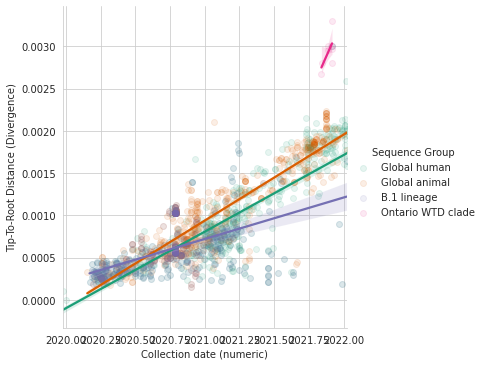

In [61]:
sns.lmplot(data = tip_to_tree_data, x='Collection date (numeric)', y='Tip-To-Root Distance (Divergence)', hue='Sequence Group', scatter_kws={'alpha': 0.1})

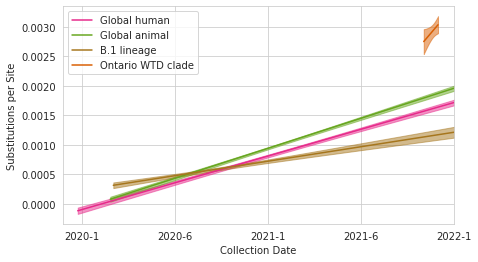

In [101]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
fit_data = {}
n_std=2

color_palette = {'Global human': '#e7298a', 'Global animal': '#66a61e', 'B.1 lineage': '#a6761d', 'Ontario WTD clade': '#d95f02'}
for sequence_group in tip_to_tree_data['Sequence Group'].unique():
    group_data = tip_to_tree_data[tip_to_tree_data['Sequence Group'] == sequence_group]    
    x = group_data['Collection date (numeric)']
    y = group_data['Tip-To-Root Distance (Divergence)']
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(endog=y, exog=x_fit).fit()
    #fit_results = sm.OLS(endog=y, exog=x).fit()

    fit_data[sequence_group] = fit_results
    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), 100))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {}# if ci_kws is None else ci_kws
    
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        color=color_palette[sequence_group],
        **ci_kws,
    )
    ax.plot(
        eval_x[:, 1],
        pred.predicted_mean,
        label = sequence_group,
        color=color_palette[sequence_group],

    )
    
#     ax.scatter(x, y, alpha=0.1
#     )

plt.ylabel('Substitutions per Site')
plt.xlabel('Collection Date')
plt.xlim(2019.9, 2022)
lab, ticks = plt.xticks()
plt.legend()
positions = (2020, 2020.5, 2021, 2021.5, 2022)
labels = ("2020-1", "2020-6", "2021-1", "2021-6", "2022-1")
plt.xticks(positions, labels)
plt.savefig('../../figures/intermediate/rrt.svg', dpi=300, bbox_inches='tight')


In [100]:
for key in fit_data.keys():
    print(key)
    conf = fit_data[key].conf_int().loc['Collection date (numeric)']
    print(f"{fit_data[key].params.loc['Collection date (numeric)']:.4f} ({conf[0]:.4f}-{conf[1]:.4f})")


Global human
0.0009 (0.0009-0.0010)
Global animal
0.0010 (0.0010-0.0011)
B.1 lineage
0.0005 (0.0004-0.0006)
Ontario WTD clade
0.0037 (-0.0006-0.0081)
